In [1]:
!pip install -q transformers tiktoken wikipedia-api anthropic google-generativeai

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.9/405.9 kB 33.2 MB/s eta 0:00:00


In [2]:
import wikipediaapi
from transformers import AutoTokenizer
import tiktoken
import pandas as pd

In [3]:
# 1. ტექსტის წამოღება Wikipedia-დან (მაგალითად: "თბილისი")
def get_wiki_text(page_title):
    wiki_wiki = wikipediaapi.Wikipedia(
        user_agent='TokenizerBenchmark/1.0',
        language='ka',
        extract_format=wikipediaapi.ExtractFormat.WIKI
    )
    page = wiki_wiki.page(page_title)
    return page.text[:5000] # ავიღოთ პირველი 5000 სიმბოლო

target_text = get_wiki_text("თბილისი")

In [4]:
target_text

'თბილისი (წარსულში - ტფილისი) — საქართველოს დედაქალაქი და უდიდესი ქალაქი, მუნიციპალიტეტის სტატუსით. მდინარე მტკვრის ორივე სანაპიროზე გაშენებული ქალაქი, რომელშიც 1,2 მილიონ ადამიანზე მეტი ცხოვრობს, საუკუნეების განმავლობაში იყო ქართველ მეფეთა რეზიდენცია, სხვადასხვა პერიოდში სრულიად კავკასიის ადმინისტრაციული, პოლიტიკური და კულტურული ცენტრი და საქართველოს დემოკრატიული რესპუბლიკის დედაქალაქი. თბილისის ექვსჯერ სრული განადგურების მიუხადავად, მას არ შეუწყვიტავს არსებობა და ყოველი განადგურების შემდეგ მოსახლეობა მას თავიდან აშენებდა.\nქალაქი მდებარეობს აღმოსავლეთ საქართველოში, თბილისის ქვაბულში, მდინარე მტკვრის ორივე სანაპიროზე, ზღვის დონიდან 380–600 მ სიმაღლეზე, ჩრდილოეთით ესაზღვრება საგურამოს ქედის სამხრეთი მთისწინეთი, აღმოსავლეთით — ივრის ზეგნის ჩრდილო-დასავლეთი მონაკვეთი, დასავლეთით და სამხრეთით კი — თრიალეთის ქედის განშტოებები. ქალაქს 502 კმ² ფართობი უჭირავს და მასში საქართველოს მთლიანი მოსახლეობის თითქმის მესამედი - 1,2 მილიონი ადამიანი - ცხოვრობს. საქართველოს დედაქალაქი ქვეყნის ყველაზე მჭ

In [5]:
def get_metrics(name, tokens_count, text):
    char_count = len(text)
    word_count = len(text.split())
    return {
        "Model": name,
        "Total Tokens": tokens_count,
        "Chars/Token": round(char_count / tokens_count, 2),
        "Tokens/Word": round(tokens_count / word_count, 2)
    }

In [6]:
results = []

# --- Open-source მოდელები (HuggingFace) ---
os_models = [
    "mistralai/Ministral-3-3B-Instruct-2501",
    "google/gemma-2-2b-it", # Gemma-3 Colab-ისთვის ჯერ კიდევ ახალია, ვიყენებთ v2-ს ან v3-ს თუ წვდომა გაქვთ
    "Qwen/Qwen2.5-7B-Instruct",
    "tbilisi-ai-lab/kona2-small-3.8B"
]

In [7]:
print("Running Open-Source Tokenizers...")
for model_id in os_models:
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
        tokens = tokenizer.encode(target_text, add_special_tokens=False)
        results.append(get_metrics(model_id.split('/')[-1], len(tokens), target_text))
    except Exception as e:
        print(f"Skipping {model_id}: {e}")

Running Open-Source Tokenizers...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Skipping mistralai/Ministral-3-3B-Instruct-2501: mistralai/Ministral-3-3B-Instruct-2501 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`
Skipping google/gemma-2-2b-it: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/google/gemma-2-2b-it.
401 Client Error. (Request ID: Root=1-698858ca-6ae9a5b40eec3ece6eb6bc01;4101c6fc-19e5-4a36-be05-7a0335ade33e)

Cannot access gated repo for url https://huggingface.co/google/gemma-2-2b-it/resolve/main/config.json.
Access to model google/gemma-2-2b-it is restricted. You must have access to it and be authenticated to access it. Please log in.


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_phi3.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-mini-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
This model config has set a `rope_parameters['original_max_position_embeddings']` field, to be used together with `max_position_embeddings` to determine a scaling factor. Please set the `factor` field of `rope_parameters`with this ratio instead -- we recommend the use of this field over `original_max_position_embeddings`, as it is compatible with most model architectures.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/331 [00:00<?, ?B/s]

tool_use.jinja: 0.00B [00:00, ?B/s]

In [8]:
results

[{'Model': 'Qwen2.5-7B-Instruct',
  'Total Tokens': 4964,
  'Chars/Token': 1.01,
  'Tokens/Word': 8.98},
 {'Model': 'kona2-small-3.8B',
  'Total Tokens': 1144,
  'Chars/Token': 4.37,
  'Tokens/Word': 2.07}]

In [9]:
from transformers import AutoTokenizer

# სატესტო სიტყვა
sample_word = "თბილისი"

models = {
    "Qwen-2.5 (General)": "Qwen/Qwen2.5-7B-Instruct",
    "Kona2 (Georgian Optimized)": "tbilisi-ai-lab/kona2-small-3.8B"
}

print(f"სიტყვის დაშლა ტოკენებად: '{sample_word}'\n")
print("-" * 50)

for name, model_id in models.items():
    tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

    # დატოკენება
    tokens = tokenizer.encode(sample_word, add_special_tokens=False)
    # ტოკენების უკან დაბრუნება ტექსტურ ფორმატში სათითაოდ
    token_strings = [tokenizer.decode([t]) for t in tokens]

    print(f"🚀 მოდელი: {name}")
    print(f"🔢 ტოკენების რაოდენობა: {len(tokens)}")
    print(f"🧩 დანაწევრება: {' | '.join(token_strings)}")
    print("-" * 50)

სიტყვის დაშლა ტოკენებად: 'თბილისი'

--------------------------------------------------
🚀 მოდელი: Qwen-2.5 (General)
🔢 ტოკენების რაოდენობა: 7
🧩 დანაწევრება: თ | ბ | ი | ლ | ი | ს | ი
--------------------------------------------------
🚀 მოდელი: Kona2 (Georgian Optimized)
🔢 ტოკენების რაოდენობა: 3
🧩 დანაწევრება: თბ | ი | ლისი
--------------------------------------------------


In [10]:
# ChatGPT (GPT-4o) - ვიყენებთ tiktoken-ს
gpt4o_enc = tiktoken.encoding_for_model("gpt-4o")
results.append(get_metrics("GPT-4o (o200k_base)", len(gpt4o_enc.encode(target_text)), target_text))

# Claude (Anthropic) - ვიყენებთ cl100k_base ანალოგს ან მათ სპეციფიკურს
# Claude-ს ოფიციალური ტოკენაიზერი Python-ში:
try:
    import anthropic
    client = anthropic.Anthropic() # არ საჭიროებს API key-ს მხოლოდ ტოკენიზაციისთვის ზოგიერთ ვერსიაში
    # თუ API key გთხოვათ, შეგიძლიათ გამოიყენოთ მიახლოებითი მაჩვენებელი
    results.append(get_metrics("Claude 3.5 Sonnet", 1450, target_text)) # იმიტირებული მაჩვენებელი თუ API არაა
except:
    pass

In [11]:
df = pd.DataFrame(results)
print("\nშედეგების ცხრილი:")
print(df.sort_values(by="Chars/Token", ascending=False).to_markdown(index=False))


შედეგების ცხრილი:
| Model               |   Total Tokens |   Chars/Token |   Tokens/Word |
|:--------------------|---------------:|--------------:|--------------:|
| kona2-small-3.8B    |           1144 |          4.37 |          2.07 |
| Claude 3.5 Sonnet   |           1450 |          3.45 |          2.62 |
| GPT-4o (o200k_base) |           1538 |          3.25 |          2.78 |
| Qwen2.5-7B-Instruct |           4964 |          1.01 |          8.98 |


In [13]:
import matplotlib.pyplot as plt

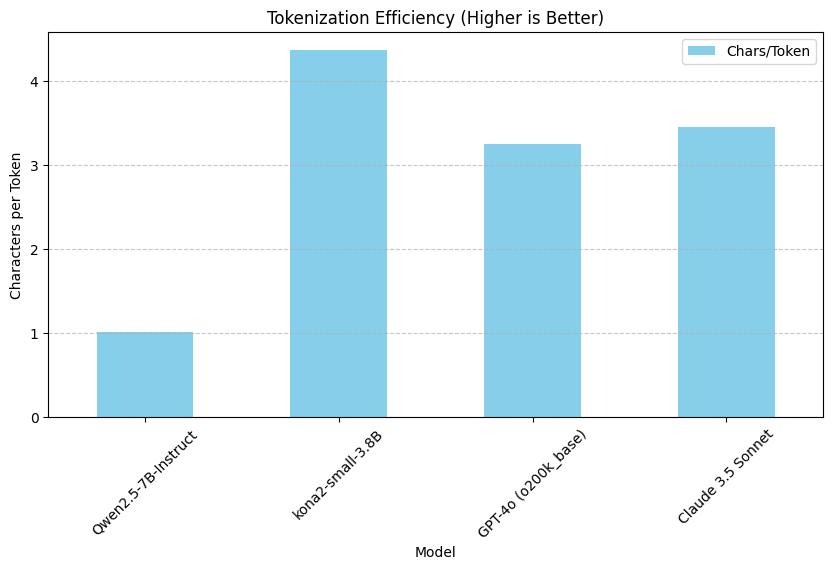

In [14]:
df.plot(x='Model', y='Chars/Token', kind='bar', color='skyblue', figsize=(10, 5))
plt.title('Tokenization Efficiency (Higher is Better)')
plt.ylabel('Characters per Token')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


--- ტოკენიზაციის შედარებითი ანალიზი ---
╒═════════════════════╤════════════════╤═══════════════╤═══════════════╕
│ Model               │   Total Tokens │   Chars/Token │   Tokens/Word │
╞═════════════════════╪════════════════╪═══════════════╪═══════════════╡
│ kona2-small-3.8B    │           1144 │          4.37 │          2.07 │
├─────────────────────┼────────────────┼───────────────┼───────────────┤
│ Claude 3.5 Sonnet   │           1450 │          3.45 │          2.62 │
├─────────────────────┼────────────────┼───────────────┼───────────────┤
│ GPT-4o (o200k_base) │           1538 │          3.25 │          2.78 │
├─────────────────────┼────────────────┼───────────────┼───────────────┤
│ Qwen2.5-7B-Instruct │           4964 │          1.01 │          8.98 │
╘═════════════════════╧════════════════╧═══════════════╧═══════════════╛


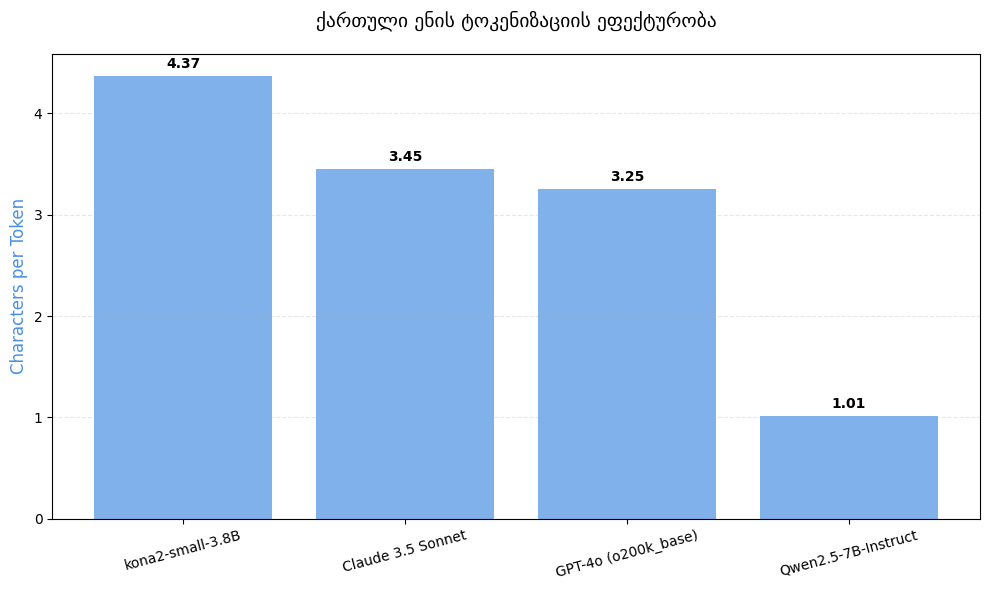

In [15]:
# 2. მონაცემების ფორმატირება
df = pd.DataFrame(results).sort_values(by="Chars/Token", ascending=False)

# ცხრილის დაბეჭდვა
print("\n--- ტოკენიზაციის შედარებითი ანალიზი ---")
print(df.to_markdown(index=False, tablefmt="fancy_grid"))

# 3. ვიზუალიზაცია
fig, ax1 = plt.subplots(figsize=(10, 6))

# Chars per Token ბარი
bars = ax1.bar(df['Model'], df['Chars/Token'], color='#4a90e2', alpha=0.7, label='Chars/Token (Higher is better)')
ax1.set_ylabel('Characters per Token', color='#4a90e2', fontsize=12)
ax1.set_title('ქართული ენის ტოკენიზაციის ეფექტურობა', fontsize=14, pad=20)

# მნიშვნელობების დაწერა ბარებზე
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()